<a href="https://colab.research.google.com/github/ZahraReyhanian/DGM/blob/main/Denoising_Diffusion_Probabilistic_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Deep Generative Models Course</font></span>
        <span><br><font size=3>Fall 2022</font></span>
    </div><br><br><br>
    <div style="display:block" align=left display=block>
        <font size=3>Homework 3</font><br>
        <hr />
        <font size=3>TA: <a href="mailto:p.zilouchian@ut.ac.ir">Parham Zilouchian</a><br></font><br>
    </div>
</div>

# **Part1: Diffusion Models and Latent Diffusion**



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 20 11:29:49 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Section 1: Overview of Diffusion Models

Let's begin by seeing where diffusion models fit within the zoo of generative models in use today:

![model type diag](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/generative-overview.png)
Overview of different types of generative models. (from [this great blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/))

The core concept behind these models is deceptively simple:
- Take a starting image
- Add some noise, iteratively degrading the image until almost nothing but noise remains.
- Train a model to 'undo' these noise steps.
- To generate, start from pure noise and repeatedly apply the model to 'denoise' our way back to a plausible image.

The model generally has access to some representation of 't' - that is, how many noise steps have been applied to the image. And to make its job easier, we typically get the model to output a prediction for the *noise* that we could subtract from the noisy image to get a less noisy one, rather than spitting out the denoised image.

With this high-level idea in our heads, let's have a go at implementing one!


# Section 2: Implementing One



In [ ]:
# @title Install requirements
!pip install datasets &>> install.log

In [ ]:
#@title imports and utility functions
from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F
import os
from tqdm.notebook import tqdm
import torch
import numpy as np
from torchvision import datasets, transforms
from torchvision.datasets.utils import download_url


def img_to_tensor(im):
  return torch.tensor(np.array(im.convert('RGB'))/255).permute(2, 0, 1).unsqueeze(0) * 2 - 1

def tensor_to_image(t):
  return Image.fromarray(np.array(((t.squeeze().permute(1, 2, 0)+1)/2).clip(0, 1)*255).astype(np.uint8))

def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for $t$ and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

## 2.1 Dataset

We'll start with a classic small dataset, with 32px square images from 10 classes. For convenience we just pull a version that is avalable on the huggingface hub.

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

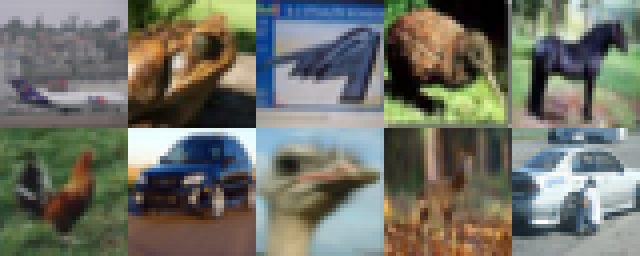

In [ ]:
#@title cifar10 - 32px images in 10 classes

# Download and load the dataset
cifar10 = load_dataset('cifar10')

# View some examples:
image = Image.new('RGB', size=(32*5, 32*2))
for i in range(10):
  im = cifar10['train'][i]['img']
  image.paste(im, ( (i%5)*32, (i//5)*32 ))
image.resize((32*5*4, 32*2*4), Image.NEAREST)

In [ ]:
# @title alternative dataset: faces (CelebA) - uncomment to run
# faces = load_dataset('huggan/CelebA-faces')

## 2.2 Adding Noise

First, we want to define the spet that adds a little bit of noise - $q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$:

![process](https://datasciencecastnethome.files.wordpress.com/2022/04/screenshot-from-2022-04-12-14-55-09.png) [(Image source)](https://hojonathanho.github.io/diffusion/)

We set up a 'variance schedule' β, where beta[t] ($\beta_t$)specifies how much noise we want to add at that step. You get fancy schedules but we'll stick with a linear one for now. The formula you'll see for this single noise step is:

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$

We mix $\mathbf{x}_{t-1}$ with some gaussian noise, with how much noise decided by $\beta_t$. Let's see this in code and try applying it a bunch of times to an image:

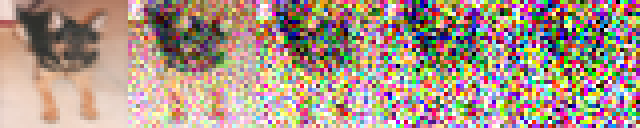

In [ ]:
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)

def q_xt_xtminus1(xtm1, t):
  ################################################################################
    # TODO: complete the code here
    # Complete this function using the equation above to generate noise
    beta_t = gather(beta, t)
    mean = (1. - beta_t).sqrt() * xtm1
    std = beta_t.sqrt()
    return mean + std * torch.randn(*xtm1.shape)
    # End
    ################################################################################

# Show im at different stages
ims = []
start_im = cifar10['train'][10]['img']
x = img_to_tensor(start_im).squeeze()
for t in range(n_steps):

  # Store images every 20 steps to show progression
  if t%20 == 0:
    ims.append(tensor_to_image(x))

  # Calculate Xt given Xt-1 (i.e. x from the previous iteration)
  t = torch.tensor(t, dtype=torch.long) # t as a tensor
  x = q_xt_xtminus1(x, t) # Modify x using our function above

# Display the images
image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Now, we want to train our model at different time steps and we don't particulary want to iterativly add little bits of noise a bunch of times just to train one sample from t=37.

Luckily, some smart people did some fancy maths (link https://lilianweng.github.io/posts/2018-08-12-vae/#reparameterization-trick) using something called the reparameterization trick that lets us get $x_t$ for any t given $x_0$.

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$


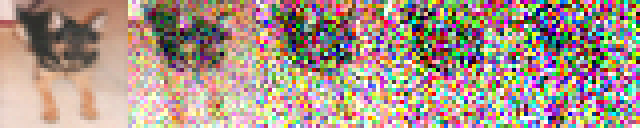

In [ ]:
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def q_xt_x0(x0, t):
  ################################################################################
    # TODO: complete the code here
    # Complete this function using the equation above to generate the appropriate noise

    alpha_bar_t = gather(alpha_bar, t)
    mean = (alpha_bar_t).sqrt()*x0
    std = (1- alpha_bar_t).sqrt()
    return mean + std * torch.randn(*x0.shape)
    # End
    ################################################################################

# Show im at different stages
ims = []
start_im = cifar10['train'][10]['img']
x0 = img_to_tensor(start_im).squeeze()
for t in [0, 20, 40, 60, 80]:
  x = q_xt_x0(x0, torch.tensor(t, dtype=torch.long)) # TODO move type to gather
  ims.append(tensor_to_image(x))

image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Note the difference: we can now calculate xt without having to do `for t in range...`.

## 2.3 UNETs

So what model do we use to do this magical 'denoising' step? We've looked a little at basic convolutional neural networks that take in an image and output something like a classification. And we've seen autoencoders that go from an image down to a latent representation and back to an output image. Perhaps one of these would be suitable?

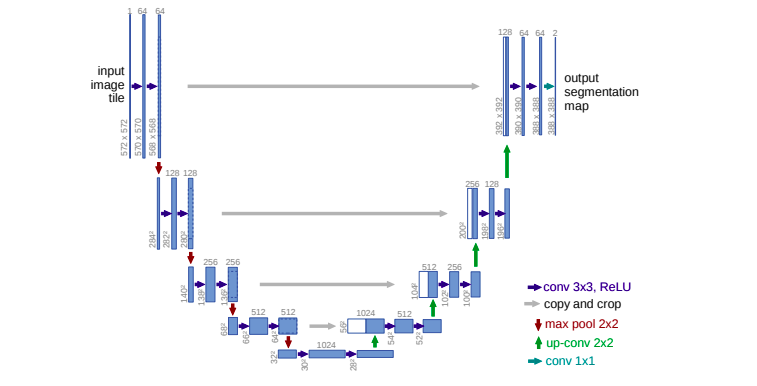

(Unet diagram from [the 2015 paper](https://arxiv.org/abs/1505.04597))

One issue with a typical 'bottlekneck' architecture like an autoencoder is that by design they loose the details around exact pixel coordinates. To get around this, an architecture called the Unet was introduced. Originally designed for segmentation tasks, the architecture (shown above) passes information from high-resolution, early layers to later layers. These 'shortcuts' let the network use detailed features from the original image while also capturing more high-level semantic information from the deeper layers.

These networks turned out to be great at all sorts of image-to-image tasks. Colorization ([deoldify](https://github.com/jantic/DeOldify)), segmentation and so on. These days, typical unet models incorporate ideas such as attention (it's all you need!) and can be built around pretrained 'backbones' like resnet-50 for transfer learning tasks.

The implementation below (taken almost verbatim from [here](https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/diffusion/ddpm/unet.py)) is a fairly typical modern Unet with one extra trick: a TimeEmbedding which encodes the time step (t) and lets the model use this as conditioning information by passing it in in the middle of the network. Take a peek at the code and see if you can figure out roughly what's going on in the forward pass.



In [ ]:
#@title Unet Definition

import math
from typing import Optional, Tuple, Union, List

import torch
from torch import nn

# A fancy activation function
class Swish(nn.Module):
    """
    ### Swish actiavation function
    $$x \cdot \sigma(x)$$
    """

    def forward(self, x):
        return x * torch.sigmoid(x)

# The time embedding
class TimeEmbedding(nn.Module):
    """
    ### Embeddings for $t$
    """

    def __init__(self, n_channels: int):
        """
        * `n_channels` is the number of dimensions in the embedding
        """
        super().__init__()
        self.n_channels = n_channels
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        self.act = Swish()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        # Create sinusoidal position embeddings

        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        #
        return emb

# Residual blocks include 'skip' connections
class ResidualBlock(nn.Module):
    """
    ### Residual block
    A residual block has two convolution layers with group normalization.
    Each resolution is processed with two residual blocks.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, n_groups: int = 32):
        """
        * `in_channels` is the number of input channels
        * `out_channels` is the number of input channels
        * `time_channels` is the number channels in the time step ($t$) embeddings
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()
        # Group normalization and the first convolution layer
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # Group normalization and the second convolution layer
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        # Linear layer for time embeddings
        self.time_emb = nn.Linear(time_channels, out_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # First convolution layer
        h = self.conv1(self.act1(self.norm1(x)))
        # Add time embeddings
        h += self.time_emb(t)[:, :, None, None]
        # Second convolution layer
        h = self.conv2(self.act2(self.norm2(h)))

        # Add the shortcut connection and return
        return h + self.shortcut(x)

# Ahh yes, magical attention...
class AttentionBlock(nn.Module):
    """
    ### Attention block
    This is similar to [transformer multi-head attention](../../transformers/mha.html).
    """

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        """
        * `n_channels` is the number of channels in the input
        * `n_heads` is the number of heads in multi-head attention
        * `d_k` is the number of dimensions in each head
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Normalization layer
        self.norm = nn.GroupNorm(n_groups, n_channels)
        # Projections for query, key and values
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Linear layer for final transformation
        self.output = nn.Linear(n_heads * d_k, n_channels)
        # Scale for dot-product attention
        self.scale = d_k ** -0.5
        #
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        # Get shape
        batch_size, n_channels, height, width = x.shape
        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = attn.softmax(dim=1)
        # Multiply by values
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        # Reshape to `[batch_size, seq, n_heads * d_k]`
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        # Transform to `[batch_size, seq, n_channels]`
        res = self.output(res)

        # Add skip connection
        res += x

        # Change to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        #
        return res


class DownBlock(nn.Module):
    """
    ### Down block
    This combines `ResidualBlock` and `AttentionBlock`. These are used in the first half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class UpBlock(nn.Module):
    """
    ### Up block
    This combines `ResidualBlock` and `AttentionBlock`. These are used in the second half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(nn.Module):
    """
    ### Middle block
    It combines a `ResidualBlock`, `AttentionBlock`, followed by another `ResidualBlock`.
    This block is applied at the lowest resolution of the U-Net.
    """

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module):
    """
    ### Scale up the feature map by $2 \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    """
    ### Scale down the feature map by $\frac{1}{2} \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)

# The core class definition (aka the important bit)
class UNet(nn.Module):
    """
    ## U-Net
    """

    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[int]] = (False, False, True, True),
                 n_blocks: int = 2):
        """
        * `image_channels` is the number of channels in the image. $3$ for RGB.
        * `n_channels` is number of channels in the initial feature map that we transform the image into
        * `ch_mults` is the list of channel numbers at each resolution. The number of channels is `ch_mults[i] * n_channels`
        * `is_attn` is a list of booleans that indicate whether to use attention at each resolution
        * `n_blocks` is the number of `UpDownBlocks` at each resolution
        """
        super().__init__()

        # Number of resolutions
        n_resolutions = len(ch_mults)

        # Project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

        # Time embedding layer. Time embedding has `n_channels * 4` channels
        self.time_emb = TimeEmbedding(n_channels * 4)

        # #### First half of U-Net - decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # #### Second half of U-Net - increasing resolution
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        # Final normalization and convolution layer
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size]`
        """

        # Get time-step embeddings
        t = self.time_emb(t)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, t)

        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #
                x = m(x, t)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))

In [ ]:
# Let's see it in action on dummy data:

# A dummy batch of 10 3-channel 32px images
x = torch.randn(10, 3, 32, 32)

# 't' - what timestep are we on
t = torch.tensor([50.], dtype=torch.long)

# Define the unet model
unet = UNet()

# The foreward pass (takes both x and t)
model_output = unet(x, t)

# The output shape matches the input.
model_output.shape

torch.Size([10, 3, 32, 32])

## 2.4 Training Time

Now that we have our 'diffusion model' defined, we need to train it to predict the noise given $x_t$ and $t$.

Why not predict the denoised image directly? Mostly just due to convenience - the noise is nicely scaled with a mean of zero, and this well-suited to being modeled with a neural network. You don't **have** to do it this way, but the papers do, and we can make it easy by tweaking our `q_xt_x0` function to return both the noised image ($x_t$) and the noise itself, which will be the 'target' our network tries to produce.

This training loop should look familiar from all the past lessons!

In [ ]:
#data loader for train and test
batch_size = 256 # Lower this if hitting memory issues
train_data = [(img_to_tensor(x['img']), x['label']) for x in cifar10['train']]
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

test_data = [(img_to_tensor(x['img']), x['label']) for x in cifar10['test']]
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [ ]:
len(train_loader)

196

In [ ]:
# path to save model
PATH = '/content/drive/MyDrive/DGM/model_ddpm.pt'

torch.cuda.empty_cache()
# Set up some parameters
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");

n_steps = 1000
beta = torch.linspace(0.0001, 0.04, n_steps, device=device)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

# Modified to return the noise itself as well
def q_xt_x0(x0, t):
################################################################################
    # TODO: complete the code here
    # Write the equation that you have witen in the previous section here again
    # This time write it based on what you want from it in the training process

    alpha_bar_t = gather(alpha_bar, t)
    mean = (alpha_bar_t).sqrt()*x0

    std = (1-alpha_bar_t).sqrt()
    noise = torch.randn_like(x0).to(device)

    x_t = mean + std * noise

    return x_t, noise

    # End
################################################################################
# Create the model
unet = UNet(n_channels=32).cuda()

# Training params
lr = 2e-4 # Explore this - might want it lower when training on the full dataset

losses = [] # Store losses for later plotting

################################################################################
    # TODO: complete the code here
    # Define the relevant Optimizer to train your model
epochs = 60
optimizer = torch.optim.AdamW(unet.parameters(), lr=lr) # Optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5) #learning rate scheduler
denoising_loss = F.mse_loss #use mean squared error fuction to calculate loss

n = len(cifar10['train'])
    # End
################################################################################



In [ ]:
# Training Loop

################################################################################
    # TODO: complete the code here
    # Write the main and forward training loop here
val_losses = []

for epoch in range(epochs):
    #train step
    unet.train()
    train_loss = 0

    #number of iteration
    it = len(train_loader)

    progress_bar = tqdm(it, total=it)
    progress_bar.set_description(f"Epoch {epoch+1}")

    for idx, (x, y) in enumerate(train_loader):
        b_size = x.shape[0]
        x, y = x.reshape(b_size,3,32,32).to(device=device), y.to(device=device)
        optimizer.zero_grad()

        t = torch.randint(0, n_steps, (b_size,), dtype=torch.long).to(device=device)
        x_t, noise = q_xt_x0(x, t)

        #predict noise using unet model
        pred_noise = unet(x_t.float(), t)

        #calculate loss
        loss = denoising_loss(noise.reshape(b_size,3,32*32).float(), pred_noise.reshape(b_size,3,32*32))
        train_loss += loss.item()

        #backpropagation
        loss.backward()

        #optimize parameters
        optimizer.step()

        progress_bar.set_postfix({"loss": train_loss / (idx + 1)})
        progress_bar.update(1)

    scheduler.step()
    print(scheduler.get_last_lr())
    losses.append(train_loss/it)
    print(f"Epoch {epoch+1}: Train Loss: {train_loss/it} ")


    # validation step
    unet.eval()
    val_loss = 0
    with torch.no_grad():
        for idx, (xv, yv) in enumerate(test_loader):
            b_size = xv.shape[0]
            xv, yv = xv.reshape(b_size,3,32,32).to(device=device), yv.to(device=device)

            t = torch.randint(0, n_steps, (b_size,), dtype=torch.long).to(device=device)
            x_t, noise = q_xt_x0(xv, t)

            pred_noise = unet(x_t.float(), t)

            # calculate validation loss
            loss = denoising_loss(noise.reshape(b_size,3,32*32), pred_noise.reshape(b_size,3,32*32))
            val_loss += loss.item()

        val_losses.append(val_loss/len(test_loader))
        print(f"Epoch {epoch+1}: Validation Loss: {val_loss/len(test_loader)} ")


    # End
################################################################################

  0%|          | 0/196 [00:00<?, ?it/s]

[0.0002]
Epoch 1: Train Loss: 0.1990503782064331 
Epoch 1: Validation Loss: 0.08063170521514122 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0002]
Epoch 2: Train Loss: 0.06196613778949392 
Epoch 2: Validation Loss: 0.04962858335173345 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0002]
Epoch 3: Train Loss: 0.04569992861159298 
Epoch 3: Validation Loss: 0.042206403549344476 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0002]
Epoch 4: Train Loss: 0.040278541266309975 
Epoch 4: Validation Loss: 0.037893231802364265 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0002]
Epoch 5: Train Loss: 0.03678524913266301 
Epoch 5: Validation Loss: 0.03492684478104014 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0002]
Epoch 6: Train Loss: 0.03395296641796523 
Epoch 6: Validation Loss: 0.03203188597505073 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0002]
Epoch 7: Train Loss: 0.03235326685505558 
Epoch 7: Validation Loss: 0.030841341491114227 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0002]
Epoch 8: Train Loss: 0.031655018227364946 
Epoch 8: Validation Loss: 0.03128243524253268 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0002]
Epoch 9: Train Loss: 0.03098215145648134 
Epoch 9: Validation Loss: 0.02996230802794455 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0002]
Epoch 10: Train Loss: 0.02958862752444586 
Epoch 10: Validation Loss: 0.02821146936442176 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0002]
Epoch 11: Train Loss: 0.02887361607875447 
Epoch 11: Validation Loss: 0.029208712157463318 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0002]
Epoch 12: Train Loss: 0.028373240217642516 
Epoch 12: Validation Loss: 0.02807985270441816 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0002]
Epoch 13: Train Loss: 0.028329241802269707 
Epoch 13: Validation Loss: 0.0275663352124556 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0002]
Epoch 14: Train Loss: 0.02812339544144212 
Epoch 14: Validation Loss: 0.027265115247991106 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0001]
Epoch 15: Train Loss: 0.027247101001973664 
Epoch 15: Validation Loss: 0.02809508177929801 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0001]
Epoch 16: Train Loss: 0.02665708269163662 
Epoch 16: Validation Loss: 0.02708943590221107 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0001]
Epoch 17: Train Loss: 0.026776284283521225 
Epoch 17: Validation Loss: 0.026796672041436896 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0001]
Epoch 18: Train Loss: 0.027154429597133885 
Epoch 18: Validation Loss: 0.027674191591296537 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0001]
Epoch 19: Train Loss: 0.026155363711319407 
Epoch 19: Validation Loss: 0.026997628354130176 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0001]
Epoch 20: Train Loss: 0.026302964307785948 
Epoch 20: Validation Loss: 0.02787662759309268 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0001]
Epoch 21: Train Loss: 0.026494894138708407 
Epoch 21: Validation Loss: 0.02728171918205527 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0001]
Epoch 22: Train Loss: 0.02640465551949277 
Epoch 22: Validation Loss: 0.02601619844891469 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0001]
Epoch 23: Train Loss: 0.02632890246352371 
Epoch 23: Validation Loss: 0.02576933816506947 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0001]
Epoch 24: Train Loss: 0.025941925227870137 
Epoch 24: Validation Loss: 0.026212426990899595 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0001]
Epoch 25: Train Loss: 0.02596278092348758 
Epoch 25: Validation Loss: 0.025658110311369102 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0001]
Epoch 26: Train Loss: 0.026232659398597116 
Epoch 26: Validation Loss: 0.026385047976308723 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0001]
Epoch 27: Train Loss: 0.025233043671338534 
Epoch 27: Validation Loss: 0.026563328583172084 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0001]
Epoch 28: Train Loss: 0.025558242811916435 
Epoch 28: Validation Loss: 0.02534144814855428 


  0%|          | 0/196 [00:00<?, ?it/s]

[0.0001]
Epoch 29: Train Loss: 0.025377497333577092 
Epoch 29: Validation Loss: 0.02553045199964184 


  0%|          | 0/196 [00:00<?, ?it/s]

[5e-05]
Epoch 30: Train Loss: 0.02543508953756976 
Epoch 30: Validation Loss: 0.024335552812922535 


  0%|          | 0/196 [00:00<?, ?it/s]

[5e-05]
Epoch 31: Train Loss: 0.025829724596851334 
Epoch 31: Validation Loss: 0.02443800961101758 


  0%|          | 0/196 [00:00<?, ?it/s]

[5e-05]
Epoch 32: Train Loss: 0.02442106749026143 
Epoch 32: Validation Loss: 0.025385513076081855 


  0%|          | 0/196 [00:00<?, ?it/s]

[5e-05]
Epoch 33: Train Loss: 0.02485386754519173 
Epoch 33: Validation Loss: 0.024335491846560163 


  0%|          | 0/196 [00:00<?, ?it/s]

[5e-05]
Epoch 34: Train Loss: 0.02545105004493071 
Epoch 34: Validation Loss: 0.024972696303425555 


  0%|          | 0/196 [00:00<?, ?it/s]

[5e-05]
Epoch 35: Train Loss: 0.02503086315772059 
Epoch 35: Validation Loss: 0.024890790466931604 


  0%|          | 0/196 [00:00<?, ?it/s]

[5e-05]
Epoch 36: Train Loss: 0.025037317365712047 
Epoch 36: Validation Loss: 0.024416401372314177 


  0%|          | 0/196 [00:00<?, ?it/s]

[5e-05]
Epoch 37: Train Loss: 0.024762257743550807 
Epoch 37: Validation Loss: 0.025050844862348914 


  0%|          | 0/196 [00:00<?, ?it/s]

[5e-05]
Epoch 38: Train Loss: 0.02503525240498842 
Epoch 38: Validation Loss: 0.02432310474589231 


  0%|          | 0/196 [00:00<?, ?it/s]

[5e-05]
Epoch 39: Train Loss: 0.025036546724791428 
Epoch 39: Validation Loss: 0.02490779507739131 


  0%|          | 0/196 [00:00<?, ?it/s]

[5e-05]
Epoch 40: Train Loss: 0.025169816086714973 
Epoch 40: Validation Loss: 0.024575434036645315 


  0%|          | 0/196 [00:00<?, ?it/s]

[5e-05]
Epoch 41: Train Loss: 0.02487858962647769 
Epoch 41: Validation Loss: 0.02518899515662814 


  0%|          | 0/196 [00:00<?, ?it/s]

[5e-05]
Epoch 42: Train Loss: 0.02444714879883187 
Epoch 42: Validation Loss: 0.025560026546363114 


  0%|          | 0/196 [00:00<?, ?it/s]

[5e-05]
Epoch 43: Train Loss: 0.02481012349492129 
Epoch 43: Validation Loss: 0.025539397900121275 


  0%|          | 0/196 [00:00<?, ?it/s]

[5e-05]
Epoch 44: Train Loss: 0.024487046025959507 
Epoch 44: Validation Loss: 0.024122538588459946 


  0%|          | 0/196 [00:00<?, ?it/s]

[2.5e-05]
Epoch 45: Train Loss: 0.024915477384490018 
Epoch 45: Validation Loss: 0.02424455337649467 


  0%|          | 0/196 [00:00<?, ?it/s]

[2.5e-05]
Epoch 46: Train Loss: 0.025024947586792464 
Epoch 46: Validation Loss: 0.025664329761857518 


  0%|          | 0/196 [00:00<?, ?it/s]

[2.5e-05]
Epoch 47: Train Loss: 0.025143278933757424 
Epoch 47: Validation Loss: 0.02481301748545272 


  0%|          | 0/196 [00:00<?, ?it/s]

[2.5e-05]
Epoch 48: Train Loss: 0.023783608862407962 
Epoch 48: Validation Loss: 0.02500749123657775 


  0%|          | 0/196 [00:00<?, ?it/s]

[2.5e-05]
Epoch 49: Train Loss: 0.024409456416128242 
Epoch 49: Validation Loss: 0.023559467722638564 


  0%|          | 0/196 [00:00<?, ?it/s]

[2.5e-05]
Epoch 50: Train Loss: 0.024748620562901606 
Epoch 50: Validation Loss: 0.024223242188507833 


  0%|          | 0/196 [00:00<?, ?it/s]

[2.5e-05]
Epoch 51: Train Loss: 0.024532204284807856 
Epoch 51: Validation Loss: 0.025066429829522768 


  0%|          | 0/196 [00:00<?, ?it/s]

[2.5e-05]
Epoch 52: Train Loss: 0.024474027918233554 
Epoch 52: Validation Loss: 0.024986633887217093 


  0%|          | 0/196 [00:00<?, ?it/s]

[2.5e-05]
Epoch 53: Train Loss: 0.02447000948940309 
Epoch 53: Validation Loss: 0.02443783767318801 


  0%|          | 0/196 [00:00<?, ?it/s]

[2.5e-05]
Epoch 54: Train Loss: 0.02483518209251366 
Epoch 54: Validation Loss: 0.025186975350102437 


  0%|          | 0/196 [00:00<?, ?it/s]

[2.5e-05]
Epoch 55: Train Loss: 0.024626745566801757 
Epoch 55: Validation Loss: 0.025107437597418476 


  0%|          | 0/196 [00:00<?, ?it/s]

[2.5e-05]
Epoch 56: Train Loss: 0.025347108743628676 
Epoch 56: Validation Loss: 0.024705314959448436 


  0%|          | 0/196 [00:00<?, ?it/s]

[2.5e-05]
Epoch 57: Train Loss: 0.024510043483151465 
Epoch 57: Validation Loss: 0.024805387669698736 


  0%|          | 0/196 [00:00<?, ?it/s]

[2.5e-05]
Epoch 58: Train Loss: 0.024683378912432462 
Epoch 58: Validation Loss: 0.02529238171606691 


  0%|          | 0/196 [00:00<?, ?it/s]

[2.5e-05]
Epoch 59: Train Loss: 0.02507362022938929 
Epoch 59: Validation Loss: 0.023902280139355945 


  0%|          | 0/196 [00:00<?, ?it/s]

[1.25e-05]
Epoch 60: Train Loss: 0.02451753924239655 
Epoch 60: Validation Loss: 0.02461253448418074 


## plot train and validation loss

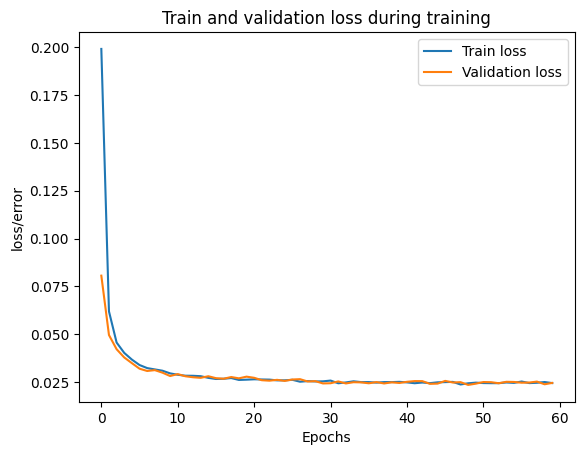

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), losses, label="Train loss")
plt.plot(range(epochs), val_losses, label="Validation loss")
plt.ylabel("loss/error")
plt.xlabel('Epochs')
plt.title("Train and validation loss during training")
plt.legend()
plt.show()

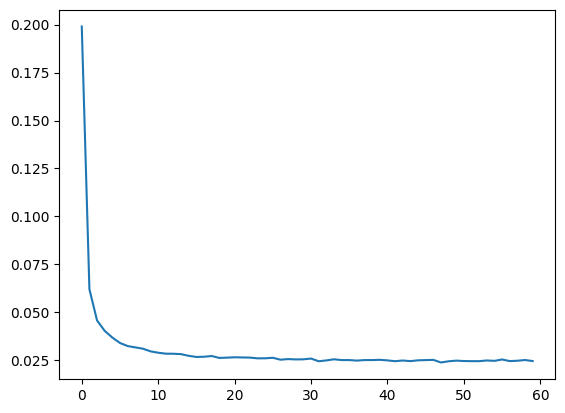

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)

### save model

In [ ]:
torch.save(unet.state_dict(), PATH)

## 2.5 The Reverse Step

Now we need to define the reverse step $p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$

See that little $_\theta$? That often indicates 'learned parameters' - in this case our unet model! We use our model to predict the noise and then 'undo' the forward noise steps one at a time to go from an image that is pure noise to one that (hopefully) looks like a real image:

In [ ]:
torch.cuda.empty_cache()

### load model

In [ ]:
model = UNet(n_channels=32).cuda()
model.load_state_dict(torch.load(PATH))
model.eval()

UNet(
  (image_proj): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb): TimeEmbedding(
    (lin1): Linear(in_features=32, out_features=128, bias=True)
    (act): Swish()
    (lin2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down): ModuleList(
    (0-1): 2 x DownBlock(
      (res): ResidualBlock(
        (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
        (act1): Swish()
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
        (act2): Swish()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Identity()
        (time_emb): Linear(in_features=128, out_features=32, bias=True)
      )
      (attn): Identity()
    )
    (2): Downsample(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (3): DownBlock(
      (res): ResidualBlock(
        (norm1): GroupNorm(

### revese step distibution

In [ ]:
def p_xt(xt, noise, t):
################################################################################
    # TODO: complete the code here
    # Write this function based on the formula given in the paper for the reverse step
    alpha_t = gather(alpha, t)
    alpha_bar_t = gather(alpha_bar, t)
    beta_t = gather(beta, t)

    eps_coef = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)
    mu = (xt - eps_coef * noise) / (torch.sqrt(alpha_t))
    z = torch.randn_like(xt)
    std = torch.sqrt(beta_t)

    xt_1 = mu + z * std
    return xt_1

    # End
################################################################################


### image generation

In [ ]:
x = torch.randn(1, 3, 32, 32).cuda() # Start with random noise
ims = []
wanted_img = [0,64,128,256,512,999]

################################################################################
    # TODO: complete the code here
    # Write the reverse step loop here
for t in range(n_steps-1,-1,-1):
    t = torch.tensor([t], dtype=torch.long).cuda()

    with torch.no_grad():
        pred_noise = model(x, t)
        x = p_xt(x, pred_noise, t)

        if t in wanted_img:
            ims.append(tensor_to_image(x.cpu().detach()))



    # End
################################################################################


### show some of steps in reverse process

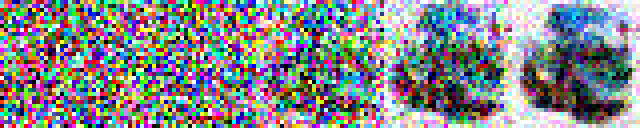

In [ ]:
image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims[:5]):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Perfect? No... Oh well, let's try a few more times:

In [ ]:
#@title Make and show 100 examples:
x = torch.randn(100, 3, 32, 32).cuda() # Start with random noise
ims = []
for i in range(n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
  with torch.no_grad():
    pred_noise = model(x.float(), t.unsqueeze(0))
    x = p_xt(x, pred_noise, t.unsqueeze(0))

for i in range(100):
  ims.append(tensor_to_image(x[i].unsqueeze(0).cpu()))

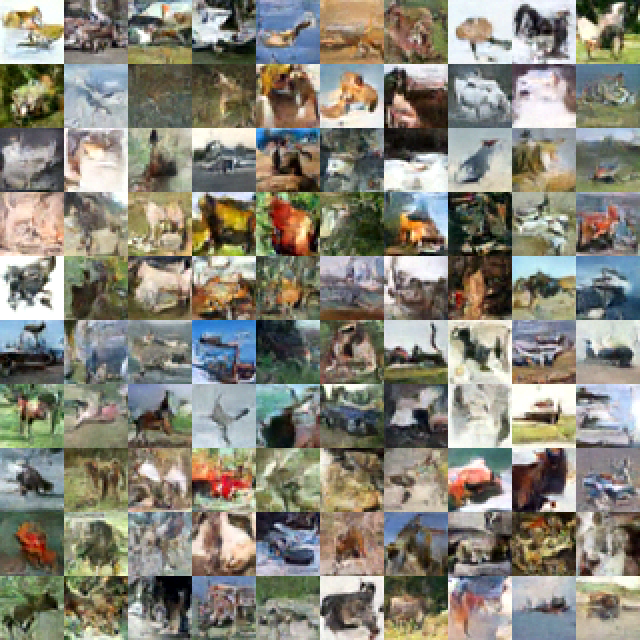

In [ ]:
image = Image.new('RGB', size=(32*10, 32*10))
for i, im in enumerate(ims):
  image.paste(im, ((i%10)*32, 32*(i//10)))
image.resize((32*2*10, 32*2*10), Image.NEAREST)



# **Part2: Evaluating the Generated Samples:**

Now we want to evaluate our model. For this, we use the FID score.

First, read [this link](https://github.com/mseitzer/pytorch-fid) to become familiar with this metric and its usage in your code.

Installation

In [ ]:
!pip install pytorch-fid &>> install.log
!pip install scipy==1.11.1 &>> install.log

### *Generate* and Save Samples

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
fake_image_path = '/content/drive/MyDrive/DGM/images_fakes'
os.mkdir(fake_image_path)

In [ ]:
from torchvision.utils import save_image

# generate 3000 samples
progress_bar = tqdm(n_steps, total=n_steps)

x = torch.randn(3000, 3, 32, 32).cuda() # Start with random noise
for i in range(n_steps):
    t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
    with torch.no_grad():
        pred_noise = model(x.float(), t.unsqueeze(0))
        x = p_xt(x, pred_noise, t.unsqueeze(0))

        progress_bar.update(1)
        # TODO: save the generated sample (x) in a directory
        # See this link: https://pytorch.org/vision/stable/generated/torchvision.utils.save_image.html
        # Be sure to assign a different name to each image!
    # fake_images_tensor.append()
for i in range(3000):
    save_image(tensor=x[i], fp=f'{fake_image_path}/img_{i}.png')




  0%|          | 0/1000 [00:00<?, ?it/s]

### save test dataset in a directory as images

In [ ]:
test_image_path = '/content/drive/MyDrive/DGM/images_test'
os.makedirs(test_image_path)

In [ ]:
i=0
for idx, (x, y) in enumerate(test_loader):
    b_size = x.shape[0]
    x = x.cuda()

    for index in range(b_size):
        img = x[index]
        save_image(tensor=img, fp=f'{test_image_path}/test_{i}.png')
        i+=1

### Compute the FID Score

In [ ]:
# TODO: compute the FID score using pytorch-fid package.
# You should have two image directories to compute the score:
# 1- Directory of the original images.
# 2- Directory of the generated images (the directory that you created in the last code cell)

!python -m pytorch_fid  /content/drive/MyDrive/DGM/images_fakes /content/drive/MyDrive/DGM/images_test

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:00<00:00, 283MB/s]
100% 60/60 [00:13<00:00,  4.60it/s]
100% 200/200 [02:52<00:00,  1.16it/s]
FID:  46.38399602523066
